In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [7]:
merged_df = pd.read_csv('../Data/merged.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='mixed', dayfirst=True, errors='coerce')
merged_df = merged_df.sort_values(["Symbol", "Date"])

merged_df.head()

,Symbol,GICS Sector,Headquarters Location,Founded,Date,Close,Volume,News - Positive Sentiment,News - Negative Sentiment,News - New Products,...,Close_lag2,Close_lag3,Close_lag4,Close_lag5,Close_lag6,Close_lag7,Close_lag8,Close_lag9,Close_lag10,Profit
0,A,Health Care,"Santa Clara, California",1999,2020-10-15,105.320000,723000,1.0,0.0,0.0,...,105.419998,105.430000,105.760002,104.160004,103.879997,101.629997,103.120003,100.010002,101.220001,1
1,A,Health Care,"Santa Clara, California",1999,2020-10-16,106.699997,1039400,0.0,0.0,1.0,...,105.059998,105.419998,105.430000,105.760002,104.160004,103.879997,101.629997,103.120003,100.010002,1
2,A,Health Care,"Santa Clara, California",1999,2020-10-19,105.489998,636000,0.0,0.0,1.0,...,105.320000,105.059998,105.419998,105.430000,105.760002,104.160004,103.879997,101.629997,103.120003,0
3,A,Health Care,"Santa Clara, California",1999,2020-10-20,105.610001,771000,2.0,0.0,0.0,...,106.699997,105.320000,105.059998,105.419998,105.430000,105.760002,104.160004,103.879997,101.629997,1
4,A,Health Care,"Santa Clara, California",1999,2020-10-21,104.830002,894000,0.0,0.0,0.0,...,105.489998,106.699997,105.320000,105.059998,105.419998,105.430000,105.760002,104.160004,103.879997,0


In [8]:
lag_cols   = [f"Close_lag{k}" for k in range(1, 11)]
news_cols  = [c for c in merged_df.columns if c.startswith("News -")]
num_features  = lag_cols + ["Volume"] + news_cols      

merged_df = pd.get_dummies(merged_df, columns=["GICS Sector"], drop_first=True, dtype="int")

sector_dummies = [c for c in merged_df.columns if c.startswith("GICS Sector_")]
feature_cols   = num_features + sector_dummies

cutoff_date = merged_df["Date"].quantile(0.8)

train = merged_df[merged_df["Date"] <= cutoff_date]
test  = merged_df[merged_df["Date"]  > cutoff_date]

X_train, y_train = train[feature_cols], train["Profit"]
X_test,  y_test  = test [feature_cols], test ["Profit"]

In [9]:
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False
)
cat_model.fit(X_train, y_train)

In [14]:
y_pred      = cat_model.predict(X_test).astype(int)           
y_pred_prob = cat_model.predict_proba(X_test)[:, 1]    

print("=== CatBoost - All Symbols ===")
print("Accuracy :",round(accuracy_score(y_test, y_pred),4))
print("ROC-AUC  :", round(roc_auc_score(y_test, y_pred_prob),4))

=== CatBoost - All Symbols ===
Accuracy : 0.5066
ROC-AUC  : 0.5174


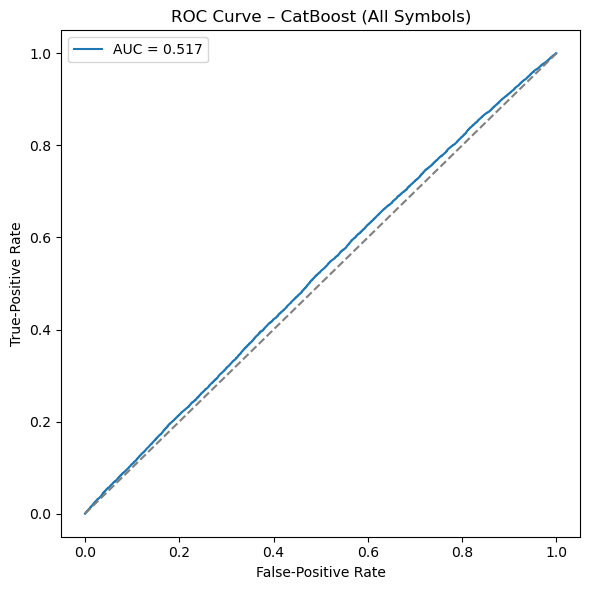

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.3f}")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve - CatBoost (All Symbols)")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Try using AAPL only
aapl = merged_df[merged_df['Symbol'] == 'AAPL'].copy()

lag_cols  = [f"Close_lag{k}" for k in range(1, 11)]

cutoff_date = aapl["Date"].quantile(0.8)

train = aapl[aapl["Date"] <= cutoff_date]
test  = aapl[aapl["Date"]  > cutoff_date]

X_train, y_train = train[feature_cols], train["Profit"]
X_test,  y_test  = test [feature_cols], test ["Profit"]

In [17]:
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False
)
cat_model.fit(X_train, y_train)

In [18]:
y_pred      = cat_model.predict(X_test).astype(int)           
y_pred_prob = cat_model.predict_proba(X_test)[:, 1]    

print("=== CatBoost - All Symbols ===")
print("Accuracy :",round(accuracy_score(y_test, y_pred),4))
print("ROC-AUC  :", round(roc_auc_score(y_test, y_pred_prob),4))

=== CatBoost - All Symbols ===
Accuracy : 0.593
ROC-AUC  : 0.603


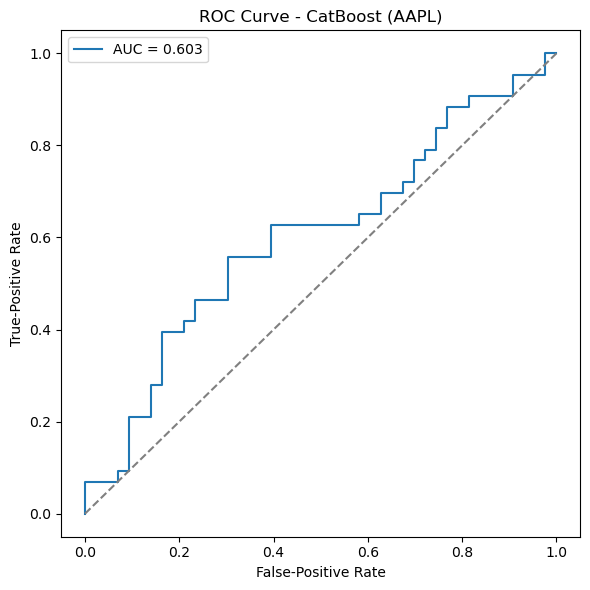

In [19]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.3f}")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve - CatBoost (AAPL)")
plt.legend()
plt.tight_layout()
plt.show()